In [ ]:
import os
import random
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
BASE_PATH = "/content/drive/MyDrive/voidModelAttempt1"
void_real_path = os.path.join(BASE_PATH, "void_true/real")
void_augmented_path = os.path.join(BASE_PATH, "void_true/augmented")
void_gan_path = os.path.join(BASE_PATH, "void_true")
plain_concrete_path = os.path.join(BASE_PATH, "void_false")

# Load real & augmented void images (keep all)
real_void_images = sorted(os.listdir(void_real_path))
augmented_void_images = sorted(os.listdir(void_augmented_path))

# Select fewer GAN images (150 instead of 300)
gan_void_images = random.sample(sorted(os.listdir(void_gan_path)), 150)

# Keep 900 plain concrete images
plain_concrete_images = random.sample(sorted(os.listdir(plain_concrete_path)),767)

# Create new dataset list
dataset = []

# Add real void & augmented void images (Label = 1)
dataset += [(os.path.join(void_real_path, img), 1) for img in real_void_images]
dataset += [(os.path.join(void_augmented_path, img), 1) for img in augmented_void_images]

# Add fewer GAN void images (Label = 1)
dataset += [(os.path.join(void_gan_path, img), 1) for img in gan_void_images]

# Add plain concrete images (Label = 0)
dataset += [(os.path.join(plain_concrete_path, img), 0) for img in plain_concrete_images]

# Create DataFrame
df = pd.DataFrame(dataset, columns=['image_path', 'label'])

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save new dataset CSV
csv_path = os.path.join(BASE_PATH, 'final_dataset_reduced_gan.csv')
df.to_csv(csv_path, index=False)

print(f"✅ Updated dataset saved at: {csv_path}")
print(df['label'].value_counts())  # Check label distribution


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Updated dataset saved at: /content/drive/MyDrive/voidModelAttempt1/final_dataset_reduced_gan.csv
label
0    767
1    767
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load dataset CSV
csv_path = "/content/drive/MyDrive/voidModelAttempt1/final_dataset_reduced_gan.csv"
df = pd.read_csv(csv_path)

# Print first few rows
print(df.head())

# Check if any paths are directories instead of files
for path in df["image_path"].head(10):
    if os.path.isdir(path):
        print(f"⚠️ Directory found instead of image: {path}")


                                          image_path  label
0  /content/drive/MyDrive/voidModelAttempt1/void_...      0
1  /content/drive/MyDrive/voidModelAttempt1/void_...      1
2  /content/drive/MyDrive/voidModelAttempt1/void_...      1
3  /content/drive/MyDrive/voidModelAttempt1/void_...      0
4  /content/drive/MyDrive/voidModelAttempt1/void_...      0


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from google.colab import drive

# Define paths
BASE_PATH = "/content/drive/MyDrive/voidModelAttempt1"
dataset_csv = os.path.join(BASE_PATH, "final_dataset_reduced_gan.csv")

# Load updated dataset
df = pd.read_csv(dataset_csv)

# Define image size
IMG_SIZE = (224, 224)

# Load Pretrained ResNet50 (Feature Extractor)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector
x = Dropout(0.3)(x)  # Apply dropout to reduce overfitting
feature_extractor = Model(inputs=base_model.input, outputs=x)

import os

# Modify function to skip non-existing paths
def extract_features(df, dataset_name):
    features, labels = [], []

    for img_path, label in tqdm(zip(df["image_path"], df["label"]), total=len(df)):
        if not os.path.isfile(img_path):  # Skip if file does not exist
            print(f"⚠️ Skipping missing file: {img_path}")
            continue

        try:
            img = load_img(img_path, target_size=IMG_SIZE)  # Load & resize image
            img = img_to_array(img)  # Convert to array
            img = preprocess_input(img)  # Normalize using ResNet50 preprocessing
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            feature_vector = feature_extractor.predict(img)  # Extract features
            features.append(feature_vector.flatten())  # Flatten feature map
            labels.append(label)

        except Exception as e:
            print(f"⚠️ Error loading image {img_path}: {e}")

    # Convert to NumPy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Save features & labels
    np.save(os.path.join(BASE_PATH, f"{dataset_name}_features.npy"), features)
    np.save(os.path.join(BASE_PATH, f"{dataset_name}_labels.npy"), labels)

    print(f"✅ {dataset_name} feature extraction complete! Saved to Drive.")



# Split new dataset into train, validation, and test
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(0.7*len(df)), int(0.85*len(df))])

# Extract & save features for Train, Validation, and Test sets
extract_features(train_df, "train_reduced_gan")
extract_features(val_df, "val_reduced_gan")
extract_features(test_df, "test_reduced_gan")


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/1073 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 1/1073 [00:02<46:36,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  0%|          | 2/1073 [00:02<21:40,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  0%|          | 3/1073 [00:03<14:49,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  0%|          | 4/1073 [00:03<10:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


  0%|          | 5/1073 [00:03<09:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  1%|          | 6/1073 [00:04<08:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


  1%|          | 7/1073 [00:04<08:00,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


  1%|          | 8/1073 [00:05<07:36,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


  1%|          | 9/1073 [00:05<07:26,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


  1%|          | 10/1073 [00:05<07:15,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


  1%|          | 11/1073 [00:06<07:09,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


  1%|          | 12/1073 [00:06<07:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  1%|          | 13/1073 [00:06<07:02,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  1%|▏         | 14/1073 [00:07<06:59,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  1%|▏         | 15/1073 [00:07<06:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  1%|▏         | 16/1073 [00:07<06:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  2%|▏         | 17/1073 [00:08<06:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  2%|▏         | 18/1073 [00:08<06:15,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  2%|▏         | 19/1073 [00:08<05:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  2%|▏         | 20/1073 [00:09<05:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  2%|▏         | 21/1073 [00:09<05:29,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|▏         | 22/1073 [00:09<05:44,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|▏         | 23/1073 [00:10<05:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  2%|▏         | 24/1073 [00:10<05:34,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  2%|▏         | 25/1073 [00:10<05:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  2%|▏         | 26/1073 [00:11<05:28,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  3%|▎         | 27/1073 [00:11<05:30,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  3%|▎         | 28/1073 [00:11<05:44,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  3%|▎         | 29/1073 [00:12<05:53,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  3%|▎         | 30/1073 [00:12<05:24,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  3%|▎         | 31/1073 [00:12<05:39,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  3%|▎         | 32/1073 [00:13<05:50,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  3%|▎         | 33/1073 [00:13<05:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  3%|▎         | 34/1073 [00:13<06:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  3%|▎         | 35/1073 [00:14<06:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  3%|▎         | 36/1073 [00:14<06:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  3%|▎         | 37/1073 [00:14<06:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▎         | 38/1073 [00:15<06:13,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  4%|▎         | 39/1073 [00:15<06:13,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  4%|▎         | 40/1073 [00:15<06:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  4%|▍         | 41/1073 [00:16<05:32,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  4%|▍         | 42/1073 [00:16<05:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▍         | 43/1073 [00:16<04:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  4%|▍         | 44/1073 [00:17<05:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


  4%|▍         | 45/1073 [00:17<05:31,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


  4%|▍         | 46/1073 [00:17<06:02,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


  4%|▍         | 47/1073 [00:18<06:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  4%|▍         | 48/1073 [00:18<08:00,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


  5%|▍         | 49/1073 [00:19<07:34,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


  5%|▍         | 50/1073 [00:19<07:15,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  5%|▍         | 51/1073 [00:20<07:04,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


  5%|▍         | 52/1073 [00:20<06:59,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  5%|▍         | 53/1073 [00:20<06:52,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  5%|▌         | 54/1073 [00:21<06:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|▌         | 55/1073 [00:21<05:48,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  5%|▌         | 56/1073 [00:21<05:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  5%|▌         | 57/1073 [00:22<06:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  5%|▌         | 58/1073 [00:22<06:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  5%|▌         | 59/1073 [00:22<06:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  6%|▌         | 60/1073 [00:23<06:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  6%|▌         | 61/1073 [00:23<05:30,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  6%|▌         | 62/1073 [00:23<05:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  6%|▌         | 63/1073 [00:24<05:25,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  6%|▌         | 64/1073 [00:24<04:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  6%|▌         | 65/1073 [00:24<05:17,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  6%|▌         | 66/1073 [00:25<04:54,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  6%|▌         | 67/1073 [00:25<04:34,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  6%|▋         | 68/1073 [00:25<04:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  6%|▋         | 69/1073 [00:25<04:54,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  7%|▋         | 70/1073 [00:26<05:17,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  7%|▋         | 71/1073 [00:26<04:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  7%|▋         | 72/1073 [00:26<05:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 73/1073 [00:27<05:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  7%|▋         | 74/1073 [00:27<05:42,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 75/1073 [00:27<05:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  7%|▋         | 76/1073 [00:28<05:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 77/1073 [00:28<05:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  7%|▋         | 78/1073 [00:28<05:34,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|▋         | 79/1073 [00:29<05:40,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|▋         | 80/1073 [00:29<05:05,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  8%|▊         | 81/1073 [00:29<04:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  8%|▊         | 82/1073 [00:30<05:06,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  8%|▊         | 83/1073 [00:30<04:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  8%|▊         | 84/1073 [00:30<05:05,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


  8%|▊         | 85/1073 [00:31<05:30,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  8%|▊         | 86/1073 [00:31<05:44,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  8%|▊         | 87/1073 [00:31<05:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  8%|▊         | 88/1073 [00:32<07:43,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


  8%|▊         | 89/1073 [00:32<07:15,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  8%|▊         | 90/1073 [00:33<07:02,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


  8%|▊         | 91/1073 [00:33<06:51,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  9%|▊         | 92/1073 [00:34<06:40,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  9%|▊         | 93/1073 [00:34<05:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  9%|▉         | 94/1073 [00:34<05:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  9%|▉         | 95/1073 [00:35<05:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  9%|▉         | 96/1073 [00:35<05:19,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  9%|▉         | 97/1073 [00:35<05:30,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  9%|▉         | 98/1073 [00:36<05:36,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  9%|▉         | 99/1073 [00:36<05:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  9%|▉         | 100/1073 [00:36<05:07,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  9%|▉         | 101/1073 [00:37<05:20,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 10%|▉         | 102/1073 [00:37<04:55,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 10%|▉         | 103/1073 [00:37<04:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 10%|▉         | 104/1073 [00:37<04:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|▉         | 105/1073 [00:38<04:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 10%|▉         | 106/1073 [00:38<05:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 10%|▉         | 107/1073 [00:38<04:39,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 10%|█         | 108/1073 [00:39<05:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 10%|█         | 109/1073 [00:39<04:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 10%|█         | 110/1073 [00:39<04:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|█         | 111/1073 [00:39<04:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|█         | 112/1073 [00:40<04:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█         | 113/1073 [00:40<04:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 11%|█         | 114/1073 [00:40<04:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 11%|█         | 115/1073 [00:40<04:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 11%|█         | 116/1073 [00:41<04:41,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 11%|█         | 117/1073 [00:41<04:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█         | 118/1073 [00:42<06:56,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 11%|█         | 119/1073 [00:42<05:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 11%|█         | 120/1073 [00:42<05:17,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 11%|█▏        | 121/1073 [00:43<05:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 11%|█▏        | 122/1073 [00:43<05:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 11%|█▏        | 123/1073 [00:43<05:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|█▏        | 124/1073 [00:44<05:17,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 12%|█▏        | 125/1073 [00:44<05:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 12%|█▏        | 126/1073 [00:45<07:13,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 12%|█▏        | 127/1073 [00:45<08:24,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 12%|█▏        | 128/1073 [00:46<07:42,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 12%|█▏        | 129/1073 [00:46<07:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 12%|█▏        | 130/1073 [00:47<07:05,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 12%|█▏        | 131/1073 [00:47<06:50,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 12%|█▏        | 132/1073 [00:47<06:33,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 12%|█▏        | 133/1073 [00:48<05:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 12%|█▏        | 134/1073 [00:48<05:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█▎        | 135/1073 [00:48<05:07,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█▎        | 136/1073 [00:49<04:43,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█▎        | 137/1073 [00:49<05:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 13%|█▎        | 138/1073 [00:49<05:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█▎        | 139/1073 [00:50<05:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 13%|█▎        | 140/1073 [00:50<05:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 13%|█▎        | 141/1073 [00:50<05:32,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█▎        | 142/1073 [00:51<05:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█▎        | 143/1073 [00:51<05:02,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 13%|█▎        | 144/1073 [00:51<05:12,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 14%|█▎        | 145/1073 [00:52<05:21,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 14%|█▎        | 146/1073 [00:52<04:51,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 14%|█▎        | 147/1073 [00:52<04:34,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 14%|█▍        | 148/1073 [00:53<04:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 14%|█▍        | 149/1073 [00:53<04:43,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|█▍        | 150/1073 [00:53<04:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|█▍        | 151/1073 [00:53<04:48,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 14%|█▍        | 152/1073 [00:54<04:26,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 14%|█▍        | 153/1073 [00:54<04:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 14%|█▍        | 154/1073 [00:54<04:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 14%|█▍        | 155/1073 [00:55<04:51,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 15%|█▍        | 156/1073 [00:55<05:04,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 15%|█▍        | 157/1073 [00:55<04:41,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 15%|█▍        | 158/1073 [00:56<05:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 15%|█▍        | 159/1073 [00:56<05:11,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 15%|█▍        | 160/1073 [00:56<04:46,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 15%|█▌        | 161/1073 [00:57<04:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 15%|█▌        | 162/1073 [00:57<04:48,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 15%|█▌        | 163/1073 [00:57<05:10,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 15%|█▌        | 164/1073 [00:58<05:29,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 15%|█▌        | 165/1073 [00:58<05:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 15%|█▌        | 166/1073 [00:59<07:10,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 16%|█▌        | 167/1073 [00:59<06:48,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 16%|█▌        | 168/1073 [01:00<06:32,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 16%|█▌        | 169/1073 [01:00<06:20,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 16%|█▌        | 170/1073 [01:00<06:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 16%|█▌        | 171/1073 [01:01<06:04,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 16%|█▌        | 172/1073 [01:01<05:53,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 16%|█▌        | 173/1073 [01:01<05:13,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 16%|█▌        | 174/1073 [01:02<05:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 16%|█▋        | 175/1073 [01:02<04:47,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▋        | 176/1073 [01:02<04:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 16%|█▋        | 177/1073 [01:03<04:40,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 17%|█▋        | 178/1073 [01:03<04:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 17%|█▋        | 179/1073 [01:03<04:41,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 17%|█▋        | 180/1073 [01:04<04:56,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 17%|█▋        | 181/1073 [01:04<05:06,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 17%|█▋        | 182/1073 [01:04<05:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 17%|█▋        | 183/1073 [01:05<05:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 17%|█▋        | 184/1073 [01:05<05:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 17%|█▋        | 185/1073 [01:05<05:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 17%|█▋        | 186/1073 [01:06<05:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 17%|█▋        | 187/1073 [01:06<05:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 18%|█▊        | 188/1073 [01:07<05:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 18%|█▊        | 189/1073 [01:07<05:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 18%|█▊        | 190/1073 [01:07<05:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 18%|█▊        | 191/1073 [01:08<05:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 18%|█▊        | 192/1073 [01:08<05:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 18%|█▊        | 193/1073 [01:08<04:50,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 18%|█▊        | 194/1073 [01:09<04:59,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 18%|█▊        | 195/1073 [01:09<04:34,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 18%|█▊        | 196/1073 [01:09<04:48,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 18%|█▊        | 197/1073 [01:09<04:23,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 18%|█▊        | 198/1073 [01:10<04:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 19%|█▊        | 199/1073 [01:10<04:31,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 19%|█▊        | 200/1073 [01:10<04:11,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 19%|█▊        | 201/1073 [01:11<04:32,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 19%|█▉        | 202/1073 [01:11<05:00,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 19%|█▉        | 203/1073 [01:12<05:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 19%|█▉        | 204/1073 [01:12<05:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 19%|█▉        | 205/1073 [01:12<05:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 19%|█▉        | 206/1073 [01:13<05:34,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 19%|█▉        | 207/1073 [01:13<05:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 19%|█▉        | 208/1073 [01:14<07:04,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 19%|█▉        | 209/1073 [01:14<06:40,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|█▉        | 210/1073 [01:14<05:42,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 20%|█▉        | 211/1073 [01:15<05:32,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|█▉        | 212/1073 [01:15<05:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|█▉        | 213/1073 [01:16<05:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|█▉        | 214/1073 [01:16<04:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|██        | 215/1073 [01:16<04:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 20%|██        | 216/1073 [01:17<05:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|██        | 217/1073 [01:17<05:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 20%|██        | 218/1073 [01:17<04:40,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|██        | 219/1073 [01:18<04:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 21%|██        | 220/1073 [01:18<04:58,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 221/1073 [01:18<05:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 222/1073 [01:19<05:04,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 21%|██        | 223/1073 [01:19<04:33,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 21%|██        | 224/1073 [01:19<04:43,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 21%|██        | 225/1073 [01:19<04:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 226/1073 [01:20<04:36,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 21%|██        | 227/1073 [01:20<04:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 228/1073 [01:21<04:53,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 21%|██▏       | 229/1073 [01:21<04:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 21%|██▏       | 230/1073 [01:21<05:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 22%|██▏       | 231/1073 [01:22<04:31,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|██▏       | 232/1073 [01:22<04:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 22%|██▏       | 233/1073 [01:22<04:51,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 22%|██▏       | 234/1073 [01:23<04:23,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 22%|██▏       | 235/1073 [01:23<04:35,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 22%|██▏       | 236/1073 [01:23<04:44,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 22%|██▏       | 237/1073 [01:24<04:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|██▏       | 238/1073 [01:24<04:34,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 22%|██▏       | 239/1073 [01:24<04:49,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 22%|██▏       | 240/1073 [01:25<05:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 22%|██▏       | 241/1073 [01:25<06:30,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 23%|██▎       | 242/1073 [01:26<06:14,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 23%|██▎       | 243/1073 [01:27<07:19,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 23%|██▎       | 244/1073 [01:27<06:46,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 23%|██▎       | 245/1073 [01:27<06:19,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 23%|██▎       | 246/1073 [01:28<06:03,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|██▎       | 247/1073 [01:28<05:44,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 23%|██▎       | 248/1073 [01:28<04:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 23%|██▎       | 249/1073 [01:29<05:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 23%|██▎       | 250/1073 [01:29<04:30,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 23%|██▎       | 251/1073 [01:29<04:41,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██▎       | 252/1073 [01:30<04:49,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 24%|██▎       | 253/1073 [01:30<04:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 24%|██▎       | 254/1073 [01:30<04:22,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 24%|██▍       | 255/1073 [01:31<04:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 24%|██▍       | 256/1073 [01:31<04:23,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 24%|██▍       | 257/1073 [01:31<04:34,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 24%|██▍       | 258/1073 [01:32<04:41,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██▍       | 259/1073 [01:32<04:46,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██▍       | 260/1073 [01:32<04:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 24%|██▍       | 261/1073 [01:33<04:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 24%|██▍       | 262/1073 [01:33<04:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 25%|██▍       | 263/1073 [01:33<04:27,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 25%|██▍       | 264/1073 [01:34<04:09,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 25%|██▍       | 265/1073 [01:34<04:24,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 25%|██▍       | 266/1073 [01:34<04:33,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██▍       | 267/1073 [01:35<04:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 25%|██▍       | 268/1073 [01:35<04:16,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 25%|██▌       | 269/1073 [01:35<04:27,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 25%|██▌       | 270/1073 [01:36<04:36,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 25%|██▌       | 271/1073 [01:36<04:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 25%|██▌       | 272/1073 [01:36<04:24,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 25%|██▌       | 273/1073 [01:37<04:33,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 26%|██▌       | 274/1073 [01:37<04:40,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 26%|██▌       | 275/1073 [01:37<04:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 26%|██▌       | 276/1073 [01:38<04:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 26%|██▌       | 277/1073 [01:38<05:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 26%|██▌       | 278/1073 [01:39<05:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 26%|██▌       | 279/1073 [01:39<05:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 26%|██▌       | 280/1073 [01:40<06:25,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 26%|██▌       | 281/1073 [01:40<05:59,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 26%|██▋       | 282/1073 [01:41<05:46,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 26%|██▋       | 283/1073 [01:41<05:34,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 26%|██▋       | 284/1073 [01:41<05:20,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|██▋       | 285/1073 [01:42<04:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 27%|██▋       | 286/1073 [01:42<04:16,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 27%|██▋       | 287/1073 [01:42<03:57,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 27%|██▋       | 288/1073 [01:42<04:12,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 27%|██▋       | 289/1073 [01:43<03:52,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 27%|██▋       | 290/1073 [01:43<04:08,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 27%|██▋       | 291/1073 [01:43<04:18,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 27%|██▋       | 292/1073 [01:44<04:28,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 27%|██▋       | 293/1073 [01:44<04:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 27%|██▋       | 294/1073 [01:44<04:11,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 27%|██▋       | 295/1073 [01:45<04:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 28%|██▊       | 296/1073 [01:45<04:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 28%|██▊       | 297/1073 [01:45<04:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 28%|██▊       | 298/1073 [01:46<04:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 28%|██▊       | 299/1073 [01:46<03:50,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 28%|██▊       | 300/1073 [01:46<04:10,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 28%|██▊       | 301/1073 [01:47<04:22,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 28%|██▊       | 302/1073 [01:47<04:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 28%|██▊       | 303/1073 [01:47<04:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 28%|██▊       | 304/1073 [01:48<04:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 28%|██▊       | 305/1073 [01:48<03:49,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 29%|██▊       | 306/1073 [01:48<04:04,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 29%|██▊       | 307/1073 [01:49<04:15,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 29%|██▊       | 308/1073 [01:49<04:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 29%|██▉       | 309/1073 [01:49<04:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 29%|██▉       | 310/1073 [01:50<04:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 29%|██▉       | 311/1073 [01:50<04:05,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 29%|██▉       | 312/1073 [01:50<03:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 29%|██▉       | 313/1073 [01:51<04:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 29%|██▉       | 314/1073 [01:51<04:14,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 29%|██▉       | 315/1073 [01:51<04:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 29%|██▉       | 316/1073 [01:52<04:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 30%|██▉       | 317/1073 [01:52<04:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 30%|██▉       | 318/1073 [01:53<04:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 30%|██▉       | 319/1073 [01:53<04:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 30%|██▉       | 320/1073 [01:53<04:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 30%|██▉       | 321/1073 [01:54<04:49,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 30%|███       | 322/1073 [01:54<04:53,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 30%|███       | 323/1073 [01:55<04:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 30%|███       | 324/1073 [01:55<04:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|███       | 325/1073 [01:55<04:52,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 30%|███       | 326/1073 [01:56<04:51,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 30%|███       | 327/1073 [01:56<04:46,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 31%|███       | 328/1073 [01:56<04:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 31%|███       | 329/1073 [01:57<04:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 31%|███       | 330/1073 [01:57<04:09,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|███       | 331/1073 [01:57<04:14,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 31%|███       | 332/1073 [01:58<04:18,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 31%|███       | 333/1073 [01:58<04:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 31%|███       | 334/1073 [01:59<04:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 31%|███       | 335/1073 [01:59<03:59,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 31%|███▏      | 336/1073 [01:59<04:09,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 31%|███▏      | 337/1073 [02:00<04:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|███▏      | 338/1073 [02:00<03:51,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 32%|███▏      | 339/1073 [02:00<04:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 32%|███▏      | 340/1073 [02:00<04:10,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 32%|███▏      | 341/1073 [02:01<04:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 342/1073 [02:01<04:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 32%|███▏      | 343/1073 [02:02<04:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 32%|███▏      | 344/1073 [02:02<03:55,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 32%|███▏      | 345/1073 [02:02<04:04,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 32%|███▏      | 346/1073 [02:03<04:12,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 32%|███▏      | 347/1073 [02:03<04:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|███▏      | 348/1073 [02:03<03:52,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 349/1073 [02:04<04:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 33%|███▎      | 350/1073 [02:04<04:09,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 33%|███▎      | 351/1073 [02:04<04:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 33%|███▎      | 352/1073 [02:05<04:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 33%|███▎      | 353/1073 [02:05<04:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 33%|███▎      | 354/1073 [02:05<04:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 33%|███▎      | 355/1073 [02:06<05:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 33%|███▎      | 356/1073 [02:07<05:23,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 33%|███▎      | 357/1073 [02:07<06:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 33%|███▎      | 358/1073 [02:08<05:56,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 33%|███▎      | 359/1073 [02:08<05:39,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▎      | 360/1073 [02:08<04:51,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|███▎      | 361/1073 [02:09<04:44,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 34%|███▎      | 362/1073 [02:09<04:12,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▍      | 363/1073 [02:09<04:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|███▍      | 364/1073 [02:10<04:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 34%|███▍      | 365/1073 [02:10<04:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 34%|███▍      | 366/1073 [02:10<03:51,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 34%|███▍      | 367/1073 [02:11<03:33,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 34%|███▍      | 368/1073 [02:11<03:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|███▍      | 369/1073 [02:11<03:38,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|███▍      | 370/1073 [02:12<03:51,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 35%|███▍      | 371/1073 [02:12<03:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 35%|███▍      | 372/1073 [02:12<03:47,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 35%|███▍      | 373/1073 [02:13<03:57,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 35%|███▍      | 374/1073 [02:13<04:03,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 35%|███▍      | 375/1073 [02:13<04:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|███▌      | 376/1073 [02:14<04:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|███▌      | 377/1073 [02:14<04:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 35%|███▌      | 378/1073 [02:14<04:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 35%|███▌      | 379/1073 [02:15<04:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 35%|███▌      | 380/1073 [02:15<04:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 36%|███▌      | 381/1073 [02:15<04:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 36%|███▌      | 382/1073 [02:16<04:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 36%|███▌      | 383/1073 [02:16<04:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 36%|███▌      | 384/1073 [02:17<04:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 36%|███▌      | 385/1073 [02:17<03:46,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|███▌      | 386/1073 [02:17<03:29,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███▌      | 387/1073 [02:17<03:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 36%|███▌      | 388/1073 [02:18<03:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 36%|███▋      | 389/1073 [02:18<03:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 36%|███▋      | 390/1073 [02:18<03:23,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 36%|███▋      | 391/1073 [02:19<03:43,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 37%|███▋      | 392/1073 [02:19<03:59,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 37%|███▋      | 393/1073 [02:19<04:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 37%|███▋      | 394/1073 [02:20<04:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 37%|███▋      | 395/1073 [02:20<04:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 37%|███▋      | 396/1073 [02:21<05:29,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 37%|███▋      | 397/1073 [02:22<06:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 37%|███▋      | 398/1073 [02:22<05:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 37%|███▋      | 399/1073 [02:22<04:51,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 37%|███▋      | 400/1073 [02:23<04:38,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 37%|███▋      | 401/1073 [02:23<04:28,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 37%|███▋      | 402/1073 [02:23<04:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 38%|███▊      | 403/1073 [02:24<04:18,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 38%|███▊      | 404/1073 [02:24<03:47,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|███▊      | 405/1073 [02:24<03:26,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 38%|███▊      | 406/1073 [02:25<03:39,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 38%|███▊      | 407/1073 [02:25<03:47,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 38%|███▊      | 408/1073 [02:25<03:53,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 38%|███▊      | 409/1073 [02:26<03:56,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 38%|███▊      | 410/1073 [02:26<03:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 38%|███▊      | 411/1073 [02:26<03:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 38%|███▊      | 412/1073 [02:27<03:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 38%|███▊      | 413/1073 [02:27<03:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 39%|███▊      | 414/1073 [02:27<03:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 39%|███▊      | 415/1073 [02:28<04:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 39%|███▉      | 416/1073 [02:28<04:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 417/1073 [02:29<04:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 39%|███▉      | 418/1073 [02:29<04:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 39%|███▉      | 419/1073 [02:29<04:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 39%|███▉      | 420/1073 [02:30<04:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 39%|███▉      | 421/1073 [02:30<03:35,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 39%|███▉      | 422/1073 [02:30<03:42,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 39%|███▉      | 423/1073 [02:31<03:47,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 40%|███▉      | 424/1073 [02:31<03:49,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 40%|███▉      | 425/1073 [02:31<03:28,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 40%|███▉      | 426/1073 [02:32<03:37,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 40%|███▉      | 427/1073 [02:32<03:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 40%|███▉      | 428/1073 [02:32<03:56,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 40%|███▉      | 429/1073 [02:33<04:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 40%|████      | 430/1073 [02:33<04:07,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 40%|████      | 431/1073 [02:34<05:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 40%|████      | 432/1073 [02:34<04:54,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 40%|████      | 433/1073 [02:35<04:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 40%|████      | 434/1073 [02:35<04:35,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 41%|████      | 435/1073 [02:35<04:23,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|████      | 436/1073 [02:36<03:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 41%|████      | 437/1073 [02:36<03:28,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 41%|████      | 438/1073 [02:36<03:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 41%|████      | 439/1073 [02:36<03:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 41%|████      | 440/1073 [02:37<02:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 41%|████      | 441/1073 [02:37<03:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 41%|████      | 442/1073 [02:37<03:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|████▏     | 443/1073 [02:38<03:18,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 41%|████▏     | 444/1073 [02:38<03:28,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 41%|████▏     | 445/1073 [02:38<03:34,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 42%|████▏     | 446/1073 [02:39<03:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 42%|████▏     | 447/1073 [02:39<03:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 42%|████▏     | 448/1073 [02:39<03:21,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 42%|████▏     | 449/1073 [02:40<03:30,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 42%|████▏     | 450/1073 [02:40<03:35,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 42%|████▏     | 451/1073 [02:41<03:38,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████▏     | 452/1073 [02:41<03:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████▏     | 453/1073 [02:41<03:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 42%|████▏     | 454/1073 [02:42<03:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 42%|████▏     | 455/1073 [02:42<03:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 42%|████▏     | 456/1073 [02:42<03:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 43%|████▎     | 457/1073 [02:43<03:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 43%|████▎     | 458/1073 [02:43<03:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 43%|████▎     | 459/1073 [02:44<03:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 43%|████▎     | 460/1073 [02:44<03:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 43%|████▎     | 461/1073 [02:44<03:22,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 43%|████▎     | 462/1073 [02:44<03:06,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 43%|████▎     | 463/1073 [02:45<03:18,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 43%|████▎     | 464/1073 [02:45<03:25,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 43%|████▎     | 465/1073 [02:46<03:37,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 43%|████▎     | 466/1073 [02:46<03:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 44%|████▎     | 467/1073 [02:46<03:54,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 44%|████▎     | 468/1073 [02:47<04:54,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 44%|████▎     | 469/1073 [02:47<04:38,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 44%|████▍     | 470/1073 [02:48<04:27,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 44%|████▍     | 471/1073 [02:49<05:17,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|████▍     | 472/1073 [02:49<04:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▍     | 473/1073 [02:49<04:28,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 44%|████▍     | 474/1073 [02:50<04:15,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 44%|████▍     | 475/1073 [02:50<03:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 44%|████▍     | 476/1073 [02:50<03:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 44%|████▍     | 477/1073 [02:51<03:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 45%|████▍     | 478/1073 [02:51<03:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|████▍     | 479/1073 [02:51<03:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 45%|████▍     | 480/1073 [02:52<03:40,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 45%|████▍     | 481/1073 [02:52<03:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 45%|████▍     | 482/1073 [02:53<03:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 45%|████▌     | 483/1073 [02:53<03:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 45%|████▌     | 484/1073 [02:53<03:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 45%|████▌     | 485/1073 [02:54<03:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 45%|████▌     | 486/1073 [02:54<03:16,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 45%|████▌     | 487/1073 [02:54<02:59,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 45%|████▌     | 488/1073 [02:54<02:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 46%|████▌     | 489/1073 [02:55<03:04,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 46%|████▌     | 490/1073 [02:55<03:13,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 46%|████▌     | 491/1073 [02:56<03:20,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 46%|████▌     | 492/1073 [02:56<03:02,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 46%|████▌     | 493/1073 [02:56<03:12,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 46%|████▌     | 494/1073 [02:56<03:01,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 46%|████▌     | 495/1073 [02:57<03:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 46%|████▌     | 496/1073 [02:57<03:16,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|████▋     | 497/1073 [02:57<03:02,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 46%|████▋     | 498/1073 [02:58<02:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 499/1073 [02:58<03:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 47%|████▋     | 500/1073 [02:58<02:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 47%|████▋     | 501/1073 [02:59<02:59,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 47%|████▋     | 502/1073 [02:59<03:13,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 47%|████▋     | 503/1073 [02:59<03:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 47%|████▋     | 504/1073 [03:00<03:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 47%|████▋     | 505/1073 [03:00<03:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 47%|████▋     | 506/1073 [03:01<04:31,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 47%|████▋     | 507/1073 [03:01<04:18,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 47%|████▋     | 508/1073 [03:02<05:03,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 47%|████▋     | 509/1073 [03:02<04:33,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 48%|████▊     | 510/1073 [03:03<03:54,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 48%|████▊     | 511/1073 [03:03<03:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 48%|████▊     | 512/1073 [03:03<03:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 48%|████▊     | 513/1073 [03:03<02:48,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 48%|████▊     | 514/1073 [03:04<02:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 515/1073 [03:04<02:55,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 48%|████▊     | 516/1073 [03:04<03:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 517/1073 [03:05<02:49,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|████▊     | 518/1073 [03:05<03:02,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 48%|████▊     | 519/1073 [03:05<03:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 48%|████▊     | 520/1073 [03:06<03:13,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 49%|████▊     | 521/1073 [03:06<02:54,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 49%|████▊     | 522/1073 [03:06<03:02,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 49%|████▊     | 523/1073 [03:07<03:08,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 49%|████▉     | 524/1073 [03:07<03:13,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 49%|████▉     | 525/1073 [03:07<03:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 49%|████▉     | 526/1073 [03:08<02:57,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 49%|████▉     | 527/1073 [03:08<03:06,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 49%|████▉     | 528/1073 [03:08<03:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 49%|████▉     | 529/1073 [03:09<03:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 49%|████▉     | 530/1073 [03:09<02:53,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 49%|████▉     | 531/1073 [03:09<03:01,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|████▉     | 532/1073 [03:10<03:06,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 50%|████▉     | 533/1073 [03:10<02:52,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|████▉     | 534/1073 [03:10<02:59,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|████▉     | 535/1073 [03:11<02:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 50%|████▉     | 536/1073 [03:11<02:54,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|█████     | 537/1073 [03:11<03:00,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|█████     | 538/1073 [03:12<03:05,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 50%|█████     | 539/1073 [03:12<03:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 50%|█████     | 540/1073 [03:13<04:05,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 50%|█████     | 541/1073 [03:13<03:56,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 51%|█████     | 542/1073 [03:14<03:52,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 51%|█████     | 543/1073 [03:14<03:46,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 51%|█████     | 544/1073 [03:15<03:42,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 51%|█████     | 545/1073 [03:15<03:36,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 51%|█████     | 546/1073 [03:15<03:33,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 51%|█████     | 547/1073 [03:16<03:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 51%|█████     | 548/1073 [03:16<03:27,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 51%|█████     | 549/1073 [03:16<03:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|█████▏    | 550/1073 [03:17<03:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 51%|█████▏    | 551/1073 [03:17<03:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 51%|█████▏    | 552/1073 [03:17<02:51,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 52%|█████▏    | 553/1073 [03:18<02:39,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|█████▏    | 554/1073 [03:18<02:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 52%|█████▏    | 555/1073 [03:18<02:42,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 52%|█████▏    | 556/1073 [03:19<02:50,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|█████▏    | 557/1073 [03:19<02:36,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 52%|█████▏    | 558/1073 [03:19<02:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 52%|█████▏    | 559/1073 [03:19<02:38,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 52%|█████▏    | 560/1073 [03:20<02:27,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 52%|█████▏    | 561/1073 [03:20<02:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 52%|█████▏    | 562/1073 [03:20<02:35,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 52%|█████▏    | 563/1073 [03:21<02:45,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 53%|█████▎    | 564/1073 [03:21<02:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|█████▎    | 565/1073 [03:21<02:44,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 53%|█████▎    | 566/1073 [03:22<02:51,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 53%|█████▎    | 567/1073 [03:22<02:36,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 53%|█████▎    | 568/1073 [03:22<02:44,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 53%|█████▎    | 569/1073 [03:23<02:52,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 570/1073 [03:23<02:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 53%|█████▎    | 571/1073 [03:23<02:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████▎    | 572/1073 [03:24<03:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 53%|█████▎    | 573/1073 [03:24<03:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 53%|█████▎    | 574/1073 [03:24<02:44,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 54%|█████▎    | 575/1073 [03:25<02:50,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 54%|█████▎    | 576/1073 [03:25<02:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 54%|█████▍    | 577/1073 [03:25<02:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 54%|█████▍    | 578/1073 [03:26<02:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 54%|█████▍    | 579/1073 [03:26<03:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 54%|█████▍    | 580/1073 [03:27<03:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 54%|█████▍    | 581/1073 [03:27<03:43,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 54%|█████▍    | 582/1073 [03:28<03:37,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 54%|█████▍    | 583/1073 [03:28<03:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 54%|█████▍    | 584/1073 [03:29<03:26,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 55%|█████▍    | 585/1073 [03:29<03:21,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 55%|█████▍    | 586/1073 [03:29<03:20,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 55%|█████▍    | 587/1073 [03:30<03:14,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 55%|█████▍    | 588/1073 [03:30<03:09,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████▍    | 589/1073 [03:31<03:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 55%|█████▍    | 590/1073 [03:31<03:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 55%|█████▌    | 591/1073 [03:31<03:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 55%|█████▌    | 592/1073 [03:32<03:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 55%|█████▌    | 593/1073 [03:32<02:41,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 55%|█████▌    | 594/1073 [03:32<02:45,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 55%|█████▌    | 595/1073 [03:33<02:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 56%|█████▌    | 596/1073 [03:33<02:50,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 56%|█████▌    | 597/1073 [03:33<02:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 56%|█████▌    | 598/1073 [03:34<02:36,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 56%|█████▌    | 599/1073 [03:34<02:26,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 56%|█████▌    | 600/1073 [03:34<02:34,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 56%|█████▌    | 601/1073 [03:35<02:39,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|█████▌    | 602/1073 [03:35<02:27,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 56%|█████▌    | 603/1073 [03:35<02:34,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 56%|█████▋    | 604/1073 [03:36<02:40,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 56%|█████▋    | 605/1073 [03:36<02:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 56%|█████▋    | 606/1073 [03:36<02:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 607/1073 [03:37<02:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 57%|█████▋    | 608/1073 [03:37<02:33,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 57%|█████▋    | 609/1073 [03:37<02:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 57%|█████▋    | 610/1073 [03:38<02:30,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 57%|█████▋    | 611/1073 [03:38<02:36,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 57%|█████▋    | 612/1073 [03:38<02:41,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 57%|█████▋    | 613/1073 [03:39<02:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 57%|█████▋    | 614/1073 [03:39<02:29,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 57%|█████▋    | 615/1073 [03:39<02:35,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 57%|█████▋    | 616/1073 [03:40<02:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 58%|█████▊    | 617/1073 [03:40<03:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 58%|█████▊    | 618/1073 [03:41<03:22,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 58%|█████▊    | 619/1073 [03:42<03:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 58%|█████▊    | 620/1073 [03:42<03:40,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 58%|█████▊    | 621/1073 [03:43<04:14,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 58%|█████▊    | 622/1073 [03:43<03:48,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 58%|█████▊    | 623/1073 [03:43<03:29,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 58%|█████▊    | 624/1073 [03:44<03:15,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 58%|█████▊    | 625/1073 [03:44<03:06,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 58%|█████▊    | 626/1073 [03:45<03:00,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 58%|█████▊    | 627/1073 [03:45<02:55,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 59%|█████▊    | 628/1073 [03:45<02:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 59%|█████▊    | 629/1073 [03:46<02:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 59%|█████▊    | 630/1073 [03:46<02:31,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 59%|█████▉    | 631/1073 [03:46<02:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 59%|█████▉    | 632/1073 [03:47<02:20,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 59%|█████▉    | 633/1073 [03:47<02:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 59%|█████▉    | 634/1073 [03:47<02:19,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 59%|█████▉    | 635/1073 [03:47<02:26,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 59%|█████▉    | 636/1073 [03:48<02:31,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 59%|█████▉    | 637/1073 [03:48<02:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 59%|█████▉    | 638/1073 [03:49<02:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|█████▉    | 639/1073 [03:49<02:20,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|█████▉    | 640/1073 [03:49<02:26,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 60%|█████▉    | 641/1073 [03:49<02:13,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 60%|█████▉    | 642/1073 [03:50<02:21,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|█████▉    | 643/1073 [03:50<02:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 60%|██████    | 644/1073 [03:50<02:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 60%|██████    | 645/1073 [03:51<02:13,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|██████    | 646/1073 [03:51<02:20,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 60%|██████    | 647/1073 [03:51<02:11,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 60%|██████    | 648/1073 [03:52<02:19,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 60%|██████    | 649/1073 [03:52<02:25,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 61%|██████    | 650/1073 [03:52<02:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 61%|██████    | 651/1073 [03:53<02:29,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 61%|██████    | 652/1073 [03:53<02:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 61%|██████    | 653/1073 [03:54<03:19,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 61%|██████    | 654/1073 [03:55<03:50,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 61%|██████    | 655/1073 [03:55<03:42,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 61%|██████    | 656/1073 [03:56<04:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 61%|██████    | 657/1073 [03:57<04:21,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 61%|██████▏   | 658/1073 [03:57<03:54,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 61%|██████▏   | 659/1073 [03:58<04:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 62%|██████▏   | 660/1073 [03:58<03:47,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 62%|██████▏   | 661/1073 [03:59<03:26,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 62%|██████▏   | 662/1073 [03:59<03:09,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████▏   | 663/1073 [03:59<02:58,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 62%|██████▏   | 664/1073 [04:00<02:50,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 62%|██████▏   | 665/1073 [04:00<02:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████▏   | 666/1073 [04:00<02:15,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████▏   | 667/1073 [04:00<02:04,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████▏   | 668/1073 [04:01<02:11,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 62%|██████▏   | 669/1073 [04:01<02:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 62%|██████▏   | 670/1073 [04:02<02:20,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 63%|██████▎   | 671/1073 [04:02<02:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 63%|██████▎   | 672/1073 [04:02<02:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 63%|██████▎   | 673/1073 [04:02<02:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 63%|██████▎   | 674/1073 [04:03<02:15,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 63%|██████▎   | 675/1073 [04:03<02:04,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 63%|██████▎   | 676/1073 [04:03<02:11,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 63%|██████▎   | 677/1073 [04:04<02:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 63%|██████▎   | 678/1073 [04:04<02:03,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 63%|██████▎   | 679/1073 [04:04<01:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|██████▎   | 680/1073 [04:05<02:04,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 681/1073 [04:05<02:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████▎   | 682/1073 [04:05<02:14,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 64%|██████▎   | 683/1073 [04:06<02:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 64%|██████▎   | 684/1073 [04:06<02:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 64%|██████▍   | 685/1073 [04:06<02:05,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 64%|██████▍   | 686/1073 [04:07<02:10,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████▍   | 687/1073 [04:07<02:00,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████▍   | 688/1073 [04:07<02:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 64%|██████▍   | 689/1073 [04:08<02:11,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 64%|██████▍   | 690/1073 [04:08<02:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 64%|██████▍   | 691/1073 [04:09<02:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 64%|██████▍   | 692/1073 [04:09<03:00,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 65%|██████▍   | 693/1073 [04:10<03:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 65%|██████▍   | 694/1073 [04:10<03:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 65%|██████▍   | 695/1073 [04:11<03:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▍   | 696/1073 [04:11<02:52,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|██████▍   | 697/1073 [04:12<02:42,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 65%|██████▌   | 698/1073 [04:12<02:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|██████▌   | 699/1073 [04:12<02:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|██████▌   | 700/1073 [04:13<02:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 65%|██████▌   | 701/1073 [04:13<02:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 65%|██████▌   | 702/1073 [04:13<02:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 66%|██████▌   | 703/1073 [04:14<02:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 66%|██████▌   | 704/1073 [04:14<02:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 66%|██████▌   | 705/1073 [04:14<02:06,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▌   | 706/1073 [04:15<02:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 66%|██████▌   | 707/1073 [04:15<01:57,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 66%|██████▌   | 708/1073 [04:15<02:02,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 66%|██████▌   | 709/1073 [04:16<02:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 66%|██████▌   | 710/1073 [04:16<02:08,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 66%|██████▋   | 711/1073 [04:17<02:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 66%|██████▋   | 712/1073 [04:17<02:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▋   | 713/1073 [04:17<01:58,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 67%|██████▋   | 714/1073 [04:17<01:51,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 67%|██████▋   | 715/1073 [04:18<01:44,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 67%|██████▋   | 716/1073 [04:18<01:52,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 67%|██████▋   | 717/1073 [04:18<01:45,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 67%|██████▋   | 718/1073 [04:19<01:53,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 67%|██████▋   | 719/1073 [04:19<01:58,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 67%|██████▋   | 720/1073 [04:19<01:48,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 67%|██████▋   | 721/1073 [04:20<01:57,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 67%|██████▋   | 722/1073 [04:20<01:48,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 67%|██████▋   | 723/1073 [04:20<01:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 67%|██████▋   | 724/1073 [04:21<01:49,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 68%|██████▊   | 725/1073 [04:21<01:41,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 68%|██████▊   | 726/1073 [04:21<01:49,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 68%|██████▊   | 727/1073 [04:22<01:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 68%|██████▊   | 728/1073 [04:22<02:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 68%|██████▊   | 729/1073 [04:22<02:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 68%|██████▊   | 730/1073 [04:23<02:43,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 68%|██████▊   | 731/1073 [04:24<03:08,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 68%|██████▊   | 732/1073 [04:24<02:53,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 68%|██████▊   | 733/1073 [04:25<02:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 68%|██████▊   | 734/1073 [04:25<02:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 68%|██████▊   | 735/1073 [04:25<02:20,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 69%|██████▊   | 736/1073 [04:26<02:15,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 69%|██████▊   | 737/1073 [04:26<02:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|██████▉   | 738/1073 [04:26<02:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 69%|██████▉   | 739/1073 [04:27<02:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 69%|██████▉   | 740/1073 [04:27<02:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|██████▉   | 741/1073 [04:27<02:03,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 69%|██████▉   | 742/1073 [04:28<02:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|██████▉   | 743/1073 [04:28<02:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 69%|██████▉   | 744/1073 [04:29<02:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 69%|██████▉   | 745/1073 [04:29<02:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 70%|██████▉   | 746/1073 [04:29<01:50,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 70%|██████▉   | 747/1073 [04:30<01:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 70%|██████▉   | 748/1073 [04:30<01:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 70%|██████▉   | 749/1073 [04:30<01:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 70%|██████▉   | 750/1073 [04:31<01:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 70%|██████▉   | 751/1073 [04:31<01:47,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 70%|███████   | 752/1073 [04:31<01:50,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 70%|███████   | 753/1073 [04:32<01:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 70%|███████   | 754/1073 [04:32<01:43,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 70%|███████   | 755/1073 [04:32<01:48,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 70%|███████   | 756/1073 [04:33<01:50,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|███████   | 757/1073 [04:33<01:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 71%|███████   | 758/1073 [04:33<01:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 71%|███████   | 759/1073 [04:34<01:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 71%|███████   | 760/1073 [04:34<01:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 71%|███████   | 761/1073 [04:35<01:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 71%|███████   | 762/1073 [04:35<01:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 71%|███████   | 763/1073 [04:35<01:58,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 71%|███████   | 764/1073 [04:36<02:29,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 71%|███████▏  | 765/1073 [04:36<02:19,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 71%|███████▏  | 766/1073 [04:37<02:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 71%|███████▏  | 767/1073 [04:37<02:12,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 72%|███████▏  | 768/1073 [04:38<02:10,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 72%|███████▏  | 769/1073 [04:38<02:08,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 72%|███████▏  | 770/1073 [04:38<01:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 72%|███████▏  | 771/1073 [04:39<01:41,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 72%|███████▏  | 772/1073 [04:39<01:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 72%|███████▏  | 773/1073 [04:39<01:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 72%|███████▏  | 774/1073 [04:40<01:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 72%|███████▏  | 775/1073 [04:40<01:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 72%|███████▏  | 776/1073 [04:40<01:37,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 72%|███████▏  | 777/1073 [04:41<01:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 778/1073 [04:41<01:36,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 779/1073 [04:41<01:39,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 73%|███████▎  | 780/1073 [04:42<01:32,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|███████▎  | 781/1073 [04:42<01:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 73%|███████▎  | 782/1073 [04:42<01:32,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 73%|███████▎  | 783/1073 [04:43<01:36,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 73%|███████▎  | 784/1073 [04:43<01:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 73%|███████▎  | 785/1073 [04:43<01:34,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 786/1073 [04:44<01:37,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|███████▎  | 787/1073 [04:44<01:39,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 73%|███████▎  | 788/1073 [04:44<01:31,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 74%|███████▎  | 789/1073 [04:44<01:24,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 74%|███████▎  | 790/1073 [04:45<01:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|███████▎  | 791/1073 [04:45<01:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 74%|███████▍  | 792/1073 [04:46<01:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 74%|███████▍  | 793/1073 [04:46<01:28,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 74%|███████▍  | 794/1073 [04:46<01:32,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 74%|███████▍  | 795/1073 [04:47<01:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 74%|███████▍  | 796/1073 [04:47<01:38,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|███████▍  | 797/1073 [04:47<01:38,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 74%|███████▍  | 798/1073 [04:48<01:29,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 74%|███████▍  | 799/1073 [04:48<01:32,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 75%|███████▍  | 800/1073 [04:48<01:34,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 75%|███████▍  | 801/1073 [04:49<01:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 75%|███████▍  | 802/1073 [04:49<01:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 75%|███████▍  | 803/1073 [04:50<02:10,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 75%|███████▍  | 804/1073 [04:50<02:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 75%|███████▌  | 805/1073 [04:51<01:58,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 75%|███████▌  | 806/1073 [04:51<01:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 75%|███████▌  | 807/1073 [04:52<02:18,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 75%|███████▌  | 808/1073 [04:52<01:56,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 75%|███████▌  | 809/1073 [04:52<01:51,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 75%|███████▌  | 810/1073 [04:53<01:46,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 76%|███████▌  | 811/1073 [04:53<01:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 76%|███████▌  | 812/1073 [04:53<01:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 76%|███████▌  | 813/1073 [04:54<01:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 76%|███████▌  | 814/1073 [04:54<01:28,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 76%|███████▌  | 815/1073 [04:54<01:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 76%|███████▌  | 816/1073 [04:55<01:22,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 76%|███████▌  | 817/1073 [04:55<01:26,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 818/1073 [04:55<01:19,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 76%|███████▋  | 819/1073 [04:56<01:23,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 76%|███████▋  | 820/1073 [04:56<01:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 77%|███████▋  | 821/1073 [04:56<01:28,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 77%|███████▋  | 822/1073 [04:57<01:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 77%|███████▋  | 823/1073 [04:57<01:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 77%|███████▋  | 824/1073 [04:57<01:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 77%|███████▋  | 825/1073 [04:58<01:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 826/1073 [04:58<01:31,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 827/1073 [04:58<01:21,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 77%|███████▋  | 828/1073 [04:59<01:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 77%|███████▋  | 829/1073 [04:59<01:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 77%|███████▋  | 830/1073 [04:59<01:12,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 77%|███████▋  | 831/1073 [05:00<01:18,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 78%|███████▊  | 832/1073 [05:00<01:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 78%|███████▊  | 833/1073 [05:00<01:23,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 78%|███████▊  | 834/1073 [05:01<01:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 78%|███████▊  | 835/1073 [05:01<01:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 78%|███████▊  | 836/1073 [05:02<01:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 78%|███████▊  | 837/1073 [05:02<01:48,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 78%|███████▊  | 838/1073 [05:03<01:43,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 78%|███████▊  | 839/1073 [05:03<01:41,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 78%|███████▊  | 840/1073 [05:04<01:39,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 78%|███████▊  | 841/1073 [05:04<02:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 78%|███████▊  | 842/1073 [05:05<01:52,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 79%|███████▊  | 843/1073 [05:05<01:46,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 79%|███████▊  | 844/1073 [05:05<01:41,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 79%|███████▉  | 845/1073 [05:06<01:36,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 846/1073 [05:06<01:32,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 79%|███████▉  | 847/1073 [05:06<01:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|███████▉  | 848/1073 [05:07<01:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 79%|███████▉  | 849/1073 [05:07<01:13,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 79%|███████▉  | 850/1073 [05:07<01:16,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 79%|███████▉  | 851/1073 [05:08<01:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 79%|███████▉  | 852/1073 [05:08<01:19,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 79%|███████▉  | 853/1073 [05:08<01:11,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 80%|███████▉  | 854/1073 [05:09<01:14,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 80%|███████▉  | 855/1073 [05:09<01:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 80%|███████▉  | 856/1073 [05:10<01:16,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 80%|███████▉  | 857/1073 [05:10<01:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████▉  | 858/1073 [05:10<01:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 80%|████████  | 859/1073 [05:11<01:09,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 80%|████████  | 860/1073 [05:11<01:12,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|████████  | 861/1073 [05:11<01:13,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 80%|████████  | 862/1073 [05:12<01:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 80%|████████  | 863/1073 [05:12<01:10,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 81%|████████  | 864/1073 [05:12<01:06,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 81%|████████  | 865/1073 [05:13<01:09,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 81%|████████  | 866/1073 [05:13<01:11,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 81%|████████  | 867/1073 [05:13<01:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 81%|████████  | 868/1073 [05:14<01:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 81%|████████  | 869/1073 [05:14<01:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 81%|████████  | 870/1073 [05:14<01:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 81%|████████  | 871/1073 [05:15<01:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 81%|████████▏ | 872/1073 [05:15<01:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 81%|████████▏ | 873/1073 [05:16<01:35,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 81%|████████▏ | 874/1073 [05:17<01:50,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 82%|████████▏ | 875/1073 [05:17<01:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 82%|████████▏ | 876/1073 [05:17<01:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 82%|████████▏ | 877/1073 [05:18<01:29,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 82%|████████▏ | 878/1073 [05:18<01:26,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 82%|████████▏ | 879/1073 [05:19<01:42,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 82%|████████▏ | 880/1073 [05:19<01:25,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 82%|████████▏ | 881/1073 [05:20<01:15,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 82%|████████▏ | 882/1073 [05:20<01:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 82%|████████▏ | 883/1073 [05:20<01:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 82%|████████▏ | 884/1073 [05:20<01:01,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 82%|████████▏ | 885/1073 [05:21<01:03,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 83%|████████▎ | 886/1073 [05:21<01:05,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 83%|████████▎ | 887/1073 [05:21<01:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 83%|████████▎ | 888/1073 [05:22<01:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 83%|████████▎ | 889/1073 [05:22<01:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 83%|████████▎ | 890/1073 [05:23<01:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 83%|████████▎ | 891/1073 [05:23<01:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 83%|████████▎ | 892/1073 [05:23<01:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 83%|████████▎ | 893/1073 [05:24<01:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 83%|████████▎ | 894/1073 [05:24<00:59,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 83%|████████▎ | 895/1073 [05:24<01:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 84%|████████▎ | 896/1073 [05:25<00:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 84%|████████▎ | 897/1073 [05:25<00:59,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 84%|████████▎ | 898/1073 [05:25<00:54,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 84%|████████▍ | 899/1073 [05:25<00:51,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 84%|████████▍ | 900/1073 [05:26<00:54,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 84%|████████▍ | 901/1073 [05:26<00:57,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 84%|████████▍ | 902/1073 [05:27<00:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 84%|████████▍ | 903/1073 [05:27<01:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 84%|████████▍ | 904/1073 [05:27<01:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 84%|████████▍ | 905/1073 [05:28<01:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 84%|████████▍ | 906/1073 [05:28<01:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 85%|████████▍ | 907/1073 [05:28<00:54,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 85%|████████▍ | 908/1073 [05:29<00:56,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 85%|████████▍ | 909/1073 [05:29<00:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 85%|████████▍ | 910/1073 [05:30<01:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 85%|████████▍ | 911/1073 [05:30<01:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 85%|████████▍ | 912/1073 [05:30<01:02,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 85%|████████▌ | 913/1073 [05:31<01:03,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 85%|████████▌ | 914/1073 [05:31<01:19,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 85%|████████▌ | 915/1073 [05:32<01:14,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 85%|████████▌ | 916/1073 [05:32<01:11,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 85%|████████▌ | 917/1073 [05:33<01:03,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 86%|████████▌ | 918/1073 [05:33<01:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 86%|████████▌ | 919/1073 [05:33<00:59,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 86%|████████▌ | 920/1073 [05:34<00:53,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 86%|████████▌ | 921/1073 [05:34<00:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 86%|████████▌ | 922/1073 [05:34<00:49,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 86%|████████▌ | 923/1073 [05:35<00:51,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 86%|████████▌ | 924/1073 [05:35<00:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 86%|████████▌ | 925/1073 [05:35<00:48,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 86%|████████▋ | 926/1073 [05:36<00:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 86%|████████▋ | 927/1073 [05:36<00:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 86%|████████▋ | 928/1073 [05:36<00:52,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 87%|████████▋ | 929/1073 [05:37<00:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 87%|████████▋ | 930/1073 [05:37<00:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 87%|████████▋ | 931/1073 [05:37<00:47,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 87%|████████▋ | 932/1073 [05:38<00:48,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 87%|████████▋ | 933/1073 [05:38<00:44,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 87%|████████▋ | 934/1073 [05:38<00:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 87%|████████▋ | 935/1073 [05:39<00:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 87%|████████▋ | 936/1073 [05:39<00:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 87%|████████▋ | 937/1073 [05:39<00:41,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 87%|████████▋ | 938/1073 [05:40<00:44,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 88%|████████▊ | 939/1073 [05:40<00:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 88%|████████▊ | 940/1073 [05:40<00:43,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 88%|████████▊ | 941/1073 [05:41<00:44,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 88%|████████▊ | 942/1073 [05:41<00:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 88%|████████▊ | 943/1073 [05:41<00:42,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 88%|████████▊ | 944/1073 [05:42<00:44,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 88%|████████▊ | 945/1073 [05:42<00:44,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 88%|████████▊ | 946/1073 [05:42<00:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 88%|████████▊ | 947/1073 [05:43<00:42,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 88%|████████▊ | 948/1073 [05:43<00:56,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 88%|████████▊ | 949/1073 [05:44<01:06,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 89%|████████▊ | 950/1073 [05:45<01:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 89%|████████▊ | 951/1073 [05:45<01:17,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 89%|████████▊ | 952/1073 [05:46<01:02,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 89%|████████▉ | 953/1073 [05:46<00:52,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 89%|████████▉ | 954/1073 [05:46<00:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 89%|████████▉ | 955/1073 [05:47<00:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 89%|████████▉ | 956/1073 [05:47<00:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 89%|████████▉ | 957/1073 [05:47<00:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 89%|████████▉ | 958/1073 [05:48<00:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 89%|████████▉ | 959/1073 [05:48<00:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 89%|████████▉ | 960/1073 [05:48<00:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 90%|████████▉ | 961/1073 [05:49<00:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 90%|████████▉ | 962/1073 [05:49<00:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 90%|████████▉ | 963/1073 [05:49<00:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 90%|████████▉ | 964/1073 [05:50<00:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 90%|████████▉ | 965/1073 [05:50<00:36,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 90%|█████████ | 966/1073 [05:50<00:36,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 90%|█████████ | 967/1073 [05:51<00:33,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 90%|█████████ | 968/1073 [05:51<00:34,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 90%|█████████ | 969/1073 [05:51<00:35,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 90%|█████████ | 970/1073 [05:52<00:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 90%|█████████ | 971/1073 [05:52<00:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 91%|█████████ | 972/1073 [05:53<00:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 91%|█████████ | 973/1073 [05:53<00:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 91%|█████████ | 974/1073 [05:53<00:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 91%|█████████ | 975/1073 [05:54<00:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 91%|█████████ | 976/1073 [05:54<00:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 91%|█████████ | 977/1073 [05:54<00:31,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 91%|█████████ | 978/1073 [05:55<00:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 91%|█████████ | 979/1073 [05:55<00:33,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 91%|█████████▏| 980/1073 [05:55<00:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 91%|█████████▏| 981/1073 [05:56<00:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 92%|█████████▏| 982/1073 [05:56<00:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 92%|█████████▏| 983/1073 [05:57<00:43,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 92%|█████████▏| 984/1073 [05:58<00:49,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 92%|█████████▏| 985/1073 [05:58<00:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 92%|█████████▏| 986/1073 [05:59<00:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 92%|█████████▏| 987/1073 [05:59<00:48,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 92%|█████████▏| 988/1073 [06:00<00:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 92%|█████████▏| 989/1073 [06:00<00:38,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 92%|█████████▏| 990/1073 [06:00<00:36,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 92%|█████████▏| 991/1073 [06:01<00:34,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 92%|█████████▏| 992/1073 [06:01<00:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 93%|█████████▎| 993/1073 [06:01<00:26,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 93%|█████████▎| 994/1073 [06:02<00:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 93%|█████████▎| 995/1073 [06:02<00:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 93%|█████████▎| 996/1073 [06:02<00:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 93%|█████████▎| 997/1073 [06:02<00:24,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 93%|█████████▎| 998/1073 [06:03<00:25,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 93%|█████████▎| 999/1073 [06:03<00:25,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 93%|█████████▎| 1000/1073 [06:03<00:23,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 93%|█████████▎| 1001/1073 [06:04<00:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 93%|█████████▎| 1002/1073 [06:04<00:22,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 93%|█████████▎| 1003/1073 [06:04<00:23,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 94%|█████████▎| 1004/1073 [06:05<00:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 94%|█████████▎| 1005/1073 [06:05<00:23,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 94%|█████████▍| 1006/1073 [06:06<00:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 94%|█████████▍| 1007/1073 [06:06<00:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 94%|█████████▍| 1008/1073 [06:06<00:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 94%|█████████▍| 1009/1073 [06:07<00:23,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 94%|█████████▍| 1010/1073 [06:07<00:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 94%|█████████▍| 1011/1073 [06:07<00:20,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 94%|█████████▍| 1012/1073 [06:08<00:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 94%|█████████▍| 1013/1073 [06:08<00:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 95%|█████████▍| 1014/1073 [06:08<00:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 95%|█████████▍| 1015/1073 [06:09<00:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 95%|█████████▍| 1016/1073 [06:09<00:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 95%|█████████▍| 1017/1073 [06:10<00:26,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 95%|█████████▍| 1018/1073 [06:10<00:24,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 95%|█████████▍| 1019/1073 [06:11<00:23,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 95%|█████████▌| 1020/1073 [06:11<00:27,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 95%|█████████▌| 1021/1073 [06:12<00:25,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 95%|█████████▌| 1022/1073 [06:12<00:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 95%|█████████▌| 1023/1073 [06:13<00:21,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 95%|█████████▌| 1024/1073 [06:13<00:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 96%|█████████▌| 1025/1073 [06:13<00:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 96%|█████████▌| 1026/1073 [06:13<00:16,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 96%|█████████▌| 1027/1073 [06:14<00:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 96%|█████████▌| 1028/1073 [06:14<00:14,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 96%|█████████▌| 1029/1073 [06:14<00:13,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 96%|█████████▌| 1030/1073 [06:15<00:14,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 96%|█████████▌| 1031/1073 [06:15<00:14,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 96%|█████████▌| 1032/1073 [06:15<00:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 96%|█████████▋| 1033/1073 [06:16<00:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 96%|█████████▋| 1034/1073 [06:16<00:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 96%|█████████▋| 1035/1073 [06:17<00:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 97%|█████████▋| 1036/1073 [06:17<00:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 97%|█████████▋| 1037/1073 [06:17<00:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 97%|█████████▋| 1038/1073 [06:18<00:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 97%|█████████▋| 1039/1073 [06:18<00:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 97%|█████████▋| 1040/1073 [06:18<00:10,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 97%|█████████▋| 1041/1073 [06:19<00:11,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 97%|█████████▋| 1042/1073 [06:19<00:09,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 97%|█████████▋| 1043/1073 [06:19<00:10,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 97%|█████████▋| 1044/1073 [06:20<00:09,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 97%|█████████▋| 1045/1073 [06:20<00:09,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 97%|█████████▋| 1046/1073 [06:20<00:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 98%|█████████▊| 1047/1073 [06:21<00:08,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 98%|█████████▊| 1048/1073 [06:21<00:08,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 98%|█████████▊| 1049/1073 [06:21<00:08,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 98%|█████████▊| 1050/1073 [06:22<00:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 98%|█████████▊| 1051/1073 [06:22<00:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 98%|█████████▊| 1052/1073 [06:22<00:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 98%|█████████▊| 1053/1073 [06:23<00:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 98%|█████████▊| 1054/1073 [06:23<00:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 98%|█████████▊| 1055/1073 [06:24<00:08,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 98%|█████████▊| 1056/1073 [06:25<00:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 99%|█████████▊| 1057/1073 [06:25<00:08,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 99%|█████████▊| 1058/1073 [06:26<00:08,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 99%|█████████▊| 1059/1073 [06:26<00:06,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 99%|█████████▉| 1060/1073 [06:26<00:05,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 99%|█████████▉| 1061/1073 [06:27<00:05,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 99%|█████████▉| 1062/1073 [06:27<00:04,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 99%|█████████▉| 1063/1073 [06:28<00:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 99%|█████████▉| 1064/1073 [06:28<00:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 99%|█████████▉| 1065/1073 [06:28<00:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 99%|█████████▉| 1066/1073 [06:29<00:02,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 99%|█████████▉| 1067/1073 [06:29<00:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


100%|█████████▉| 1068/1073 [06:29<00:01,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


100%|█████████▉| 1069/1073 [06:30<00:01,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


100%|█████████▉| 1070/1073 [06:30<00:00,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


100%|█████████▉| 1071/1073 [06:30<00:00,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


100%|█████████▉| 1072/1073 [06:31<00:00,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


100%|██████████| 1073/1073 [06:31<00:00,  2.74it/s]


✅ train_reduced_gan feature extraction complete! Saved to Drive.


  0%|          | 0/230 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  0%|          | 1/230 [00:00<01:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  1%|          | 2/230 [00:00<01:14,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  1%|▏         | 3/230 [00:01<01:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  2%|▏         | 4/230 [00:01<01:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  2%|▏         | 5/230 [00:01<01:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  3%|▎         | 6/230 [00:02<01:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  3%|▎         | 7/230 [00:02<01:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  3%|▎         | 8/230 [00:02<01:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  4%|▍         | 9/230 [00:03<01:16,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  4%|▍         | 10/230 [00:03<01:09,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  5%|▍         | 11/230 [00:03<01:12,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  5%|▌         | 12/230 [00:04<01:15,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  6%|▌         | 13/230 [00:04<01:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  6%|▌         | 14/230 [00:04<01:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


  7%|▋         | 15/230 [00:05<01:39,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


  7%|▋         | 16/230 [00:05<01:35,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  7%|▋         | 17/230 [00:06<01:53,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  8%|▊         | 18/230 [00:07<02:05,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  8%|▊         | 19/230 [00:07<01:53,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  9%|▊         | 20/230 [00:08<01:35,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  9%|▉         | 21/230 [00:08<01:30,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 10%|▉         | 22/230 [00:08<01:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 10%|█         | 23/230 [00:09<01:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 10%|█         | 24/230 [00:09<01:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 11%|█         | 25/230 [00:09<01:09,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 11%|█▏        | 26/230 [00:10<01:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 12%|█▏        | 27/230 [00:10<01:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 12%|█▏        | 28/230 [00:10<01:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 13%|█▎        | 29/230 [00:11<01:08,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 13%|█▎        | 30/230 [00:11<01:03,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█▎        | 31/230 [00:11<00:58,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 14%|█▍        | 32/230 [00:12<01:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 14%|█▍        | 33/230 [00:12<01:05,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 15%|█▍        | 34/230 [00:12<01:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 15%|█▌        | 35/230 [00:13<01:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 16%|█▌        | 36/230 [00:13<01:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|█▌        | 37/230 [00:13<01:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 17%|█▋        | 38/230 [00:14<01:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 17%|█▋        | 39/230 [00:14<01:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 17%|█▋        | 40/230 [00:14<01:02,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 18%|█▊        | 41/230 [00:15<00:58,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 18%|█▊        | 42/230 [00:15<01:02,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|█▊        | 43/230 [00:15<00:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 19%|█▉        | 44/230 [00:16<01:01,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 20%|█▉        | 45/230 [00:16<01:03,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|██        | 46/230 [00:16<01:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 20%|██        | 47/230 [00:17<01:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 21%|██        | 48/230 [00:17<01:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 21%|██▏       | 49/230 [00:17<01:00,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 22%|██▏       | 50/230 [00:18<01:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 22%|██▏       | 51/230 [00:18<01:21,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 23%|██▎       | 52/230 [00:19<01:18,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 23%|██▎       | 53/230 [00:19<01:15,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 23%|██▎       | 54/230 [00:20<01:13,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 24%|██▍       | 55/230 [00:20<01:12,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 24%|██▍       | 56/230 [00:20<01:11,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 25%|██▍       | 57/230 [00:21<01:10,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 25%|██▌       | 58/230 [00:22<01:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 26%|██▌       | 59/230 [00:22<01:19,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 26%|██▌       | 60/230 [00:22<01:14,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 27%|██▋       | 61/230 [00:23<01:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 27%|██▋       | 62/230 [00:23<00:57,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 27%|██▋       | 63/230 [00:23<00:58,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 28%|██▊       | 64/230 [00:24<00:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 28%|██▊       | 65/230 [00:24<01:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 29%|██▊       | 66/230 [00:24<01:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 29%|██▉       | 67/230 [00:25<01:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 30%|██▉       | 68/230 [00:25<00:54,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 30%|███       | 69/230 [00:25<00:56,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 30%|███       | 70/230 [00:26<00:51,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 31%|███       | 71/230 [00:26<00:53,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 31%|███▏      | 72/230 [00:26<00:55,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 32%|███▏      | 73/230 [00:27<00:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 32%|███▏      | 74/230 [00:27<00:50,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 33%|███▎      | 75/230 [00:27<00:52,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 33%|███▎      | 76/230 [00:28<00:47,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 77/230 [00:28<00:51,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 34%|███▍      | 78/230 [00:28<00:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|███▍      | 79/230 [00:29<00:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 35%|███▍      | 80/230 [00:29<00:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 35%|███▌      | 81/230 [00:29<00:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 36%|███▌      | 82/230 [00:30<00:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 36%|███▌      | 83/230 [00:30<00:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 37%|███▋      | 84/230 [00:31<00:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|███▋      | 85/230 [00:31<00:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 37%|███▋      | 86/230 [00:31<00:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 38%|███▊      | 87/230 [00:32<00:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 38%|███▊      | 88/230 [00:32<01:08,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 39%|███▊      | 89/230 [00:33<01:18,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 39%|███▉      | 90/230 [00:34<01:24,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 40%|███▉      | 91/230 [00:34<01:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 40%|████      | 92/230 [00:35<01:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 40%|████      | 93/230 [00:35<00:58,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 41%|████      | 94/230 [00:35<00:56,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|████▏     | 95/230 [00:36<00:54,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 42%|████▏     | 96/230 [00:36<00:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 42%|████▏     | 97/230 [00:36<00:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 43%|████▎     | 98/230 [00:37<00:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 43%|████▎     | 99/230 [00:37<00:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 43%|████▎     | 100/230 [00:37<00:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 44%|████▍     | 101/230 [00:38<00:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▍     | 102/230 [00:38<00:42,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 45%|████▍     | 103/230 [00:38<00:39,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 45%|████▌     | 104/230 [00:39<00:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 46%|████▌     | 105/230 [00:39<00:40,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|████▌     | 106/230 [00:39<00:41,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 47%|████▋     | 107/230 [00:40<00:42,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 47%|████▋     | 108/230 [00:40<00:39,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 47%|████▋     | 109/230 [00:40<00:41,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 48%|████▊     | 110/230 [00:41<00:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 48%|████▊     | 111/230 [00:41<00:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 49%|████▊     | 112/230 [00:41<00:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 49%|████▉     | 113/230 [00:42<00:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 50%|████▉     | 114/230 [00:42<00:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 50%|█████     | 115/230 [00:42<00:38,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 50%|█████     | 116/230 [00:43<00:39,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 51%|█████     | 117/230 [00:43<00:40,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 51%|█████▏    | 118/230 [00:44<00:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 52%|█████▏    | 119/230 [00:44<00:36,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 52%|█████▏    | 120/230 [00:44<00:34,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████▎    | 121/230 [00:44<00:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|█████▎    | 122/230 [00:45<00:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 53%|█████▎    | 123/230 [00:45<00:44,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 54%|█████▍    | 124/230 [00:46<00:53,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 54%|█████▍    | 125/230 [00:47<00:59,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 55%|█████▍    | 126/230 [00:47<00:54,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 55%|█████▌    | 127/230 [00:48<00:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 56%|█████▌    | 128/230 [00:48<00:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 56%|█████▌    | 129/230 [00:48<00:44,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 57%|█████▋    | 130/230 [00:49<00:41,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 57%|█████▋    | 131/230 [00:49<00:40,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 57%|█████▋    | 132/230 [00:50<00:38,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 58%|█████▊    | 133/230 [00:50<00:37,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 58%|█████▊    | 134/230 [00:50<00:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 59%|█████▊    | 135/230 [00:51<00:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 59%|█████▉    | 136/230 [00:51<00:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 60%|█████▉    | 137/230 [00:51<00:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 60%|██████    | 138/230 [00:52<00:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 60%|██████    | 139/230 [00:52<00:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 61%|██████    | 140/230 [00:52<00:29,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 61%|██████▏   | 141/230 [00:53<00:30,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 62%|██████▏   | 142/230 [00:53<00:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 62%|██████▏   | 143/230 [00:53<00:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 63%|██████▎   | 144/230 [00:54<00:28,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 145/230 [00:54<00:29,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 63%|██████▎   | 146/230 [00:54<00:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 64%|██████▍   | 147/230 [00:55<00:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 64%|██████▍   | 148/230 [00:55<00:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|██████▍   | 149/230 [00:56<00:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 65%|██████▌   | 150/230 [00:56<00:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 66%|██████▌   | 151/230 [00:56<00:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 66%|██████▌   | 152/230 [00:57<00:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 67%|██████▋   | 153/230 [00:57<00:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 67%|██████▋   | 154/230 [00:57<00:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 67%|██████▋   | 155/230 [00:58<00:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|██████▊   | 156/230 [00:58<00:25,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 68%|██████▊   | 157/230 [00:59<00:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 69%|██████▊   | 158/230 [01:00<00:38,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 69%|██████▉   | 159/230 [01:00<00:34,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 70%|██████▉   | 160/230 [01:00<00:31,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 70%|███████   | 161/230 [01:01<00:30,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 70%|███████   | 162/230 [01:01<00:29,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 71%|███████   | 163/230 [01:01<00:28,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 71%|███████▏  | 164/230 [01:02<00:26,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 72%|███████▏  | 165/230 [01:02<00:25,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 72%|███████▏  | 166/230 [01:03<00:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 73%|███████▎  | 167/230 [01:03<00:24,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|███████▎  | 168/230 [01:03<00:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 73%|███████▎  | 169/230 [01:04<00:22,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 74%|███████▍  | 170/230 [01:04<00:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 74%|███████▍  | 171/230 [01:04<00:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 75%|███████▍  | 172/230 [01:05<00:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 75%|███████▌  | 173/230 [01:05<00:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 76%|███████▌  | 174/230 [01:06<00:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 76%|███████▌  | 175/230 [01:06<00:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 77%|███████▋  | 176/230 [01:06<00:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 77%|███████▋  | 177/230 [01:07<00:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 77%|███████▋  | 178/230 [01:07<00:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 78%|███████▊  | 179/230 [01:07<00:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 78%|███████▊  | 180/230 [01:08<00:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 79%|███████▊  | 181/230 [01:08<00:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 79%|███████▉  | 182/230 [01:08<00:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 80%|███████▉  | 183/230 [01:09<00:16,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|████████  | 184/230 [01:09<00:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 80%|████████  | 185/230 [01:10<00:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 81%|████████  | 186/230 [01:10<00:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 81%|████████▏ | 187/230 [01:10<00:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 82%|████████▏ | 188/230 [01:11<00:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 82%|████████▏ | 189/230 [01:11<00:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 83%|████████▎ | 190/230 [01:11<00:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 83%|████████▎ | 191/230 [01:12<00:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 83%|████████▎ | 192/230 [01:12<00:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 84%|████████▍ | 193/230 [01:13<00:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 84%|████████▍ | 194/230 [01:13<00:14,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 85%|████████▍ | 195/230 [01:13<00:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 85%|████████▌ | 196/230 [01:14<00:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 86%|████████▌ | 197/230 [01:14<00:13,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 86%|████████▌ | 198/230 [01:15<00:16,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 87%|████████▋ | 199/230 [01:15<00:14,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 87%|████████▋ | 200/230 [01:16<00:13,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 87%|████████▋ | 201/230 [01:16<00:12,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 88%|████████▊ | 202/230 [01:16<00:11,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 88%|████████▊ | 203/230 [01:17<00:10,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 89%|████████▊ | 204/230 [01:17<00:10,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 89%|████████▉ | 205/230 [01:18<00:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 90%|████████▉ | 206/230 [01:18<00:08,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 90%|█████████ | 207/230 [01:18<00:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 90%|█████████ | 208/230 [01:19<00:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 91%|█████████ | 209/230 [01:19<00:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 91%|█████████▏| 210/230 [01:19<00:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 92%|█████████▏| 211/230 [01:20<00:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 92%|█████████▏| 212/230 [01:20<00:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 93%|█████████▎| 213/230 [01:20<00:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 93%|█████████▎| 214/230 [01:21<00:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 93%|█████████▎| 215/230 [01:21<00:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 94%|█████████▍| 216/230 [01:21<00:04,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 94%|█████████▍| 217/230 [01:22<00:04,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 95%|█████████▍| 218/230 [01:22<00:04,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 95%|█████████▌| 219/230 [01:23<00:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 96%|█████████▌| 220/230 [01:23<00:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 96%|█████████▌| 221/230 [01:23<00:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 97%|█████████▋| 222/230 [01:24<00:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 97%|█████████▋| 223/230 [01:24<00:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 97%|█████████▋| 224/230 [01:24<00:02,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 98%|█████████▊| 225/230 [01:25<00:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 98%|█████████▊| 226/230 [01:25<00:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 99%|█████████▊| 227/230 [01:25<00:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 99%|█████████▉| 228/230 [01:26<00:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


100%|█████████▉| 229/230 [01:27<00:00,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


100%|██████████| 230/230 [01:27<00:00,  2.62it/s]


✅ val_reduced_gan feature extraction complete! Saved to Drive.


  0%|          | 0/231 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


  0%|          | 1/231 [00:00<02:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  1%|          | 2/231 [00:01<02:03,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  1%|▏         | 3/231 [00:01<01:52,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


  2%|▏         | 4/231 [00:01<01:35,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  2%|▏         | 5/231 [00:02<01:31,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  3%|▎         | 6/231 [00:02<01:29,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  3%|▎         | 7/231 [00:02<01:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  3%|▎         | 8/231 [00:03<01:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  4%|▍         | 9/231 [00:03<01:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  4%|▍         | 10/231 [00:03<01:12,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 11/231 [00:04<01:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▌         | 12/231 [00:04<01:16,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  6%|▌         | 13/231 [00:05<01:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  6%|▌         | 14/231 [00:05<01:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  6%|▋         | 15/231 [00:05<01:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  7%|▋         | 16/231 [00:06<01:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  7%|▋         | 17/231 [00:06<01:12,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  8%|▊         | 18/231 [00:06<01:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  8%|▊         | 19/231 [00:07<01:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  9%|▊         | 20/231 [00:07<01:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  9%|▉         | 21/231 [00:07<01:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 10%|▉         | 22/231 [00:08<01:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 10%|▉         | 23/231 [00:08<01:08,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 10%|█         | 24/231 [00:08<01:10,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 11%|█         | 25/231 [00:09<01:05,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 11%|█▏        | 26/231 [00:09<01:08,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|█▏        | 27/231 [00:09<01:10,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 12%|█▏        | 28/231 [00:10<01:05,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 13%|█▎        | 29/231 [00:10<01:08,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 13%|█▎        | 30/231 [00:10<01:10,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█▎        | 31/231 [00:11<01:04,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 14%|█▍        | 32/231 [00:11<01:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 14%|█▍        | 33/231 [00:11<01:05,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 15%|█▍        | 34/231 [00:12<01:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 15%|█▌        | 35/231 [00:12<01:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 16%|█▌        | 36/231 [00:13<01:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 16%|█▌        | 37/231 [00:14<01:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 16%|█▋        | 38/231 [00:14<01:37,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 17%|█▋        | 39/231 [00:15<01:50,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 17%|█▋        | 40/231 [00:15<01:38,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 18%|█▊        | 41/231 [00:15<01:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 18%|█▊        | 42/231 [00:16<01:23,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|█▊        | 43/231 [00:16<01:19,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 19%|█▉        | 44/231 [00:17<01:16,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|█▉        | 45/231 [00:17<01:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 20%|█▉        | 46/231 [00:17<01:03,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|██        | 47/231 [00:17<01:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 21%|██        | 48/231 [00:18<01:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 21%|██        | 49/231 [00:18<01:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 22%|██▏       | 50/231 [00:18<00:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 22%|██▏       | 51/231 [00:19<01:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 23%|██▎       | 52/231 [00:19<00:57,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 23%|██▎       | 53/231 [00:19<00:54,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 23%|██▎       | 54/231 [00:20<00:57,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 24%|██▍       | 55/231 [00:20<00:53,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 24%|██▍       | 56/231 [00:20<00:57,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 25%|██▍       | 57/231 [00:21<00:52,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 25%|██▌       | 58/231 [00:21<00:56,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 26%|██▌       | 59/231 [00:21<00:58,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 26%|██▌       | 60/231 [00:22<00:53,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 26%|██▋       | 61/231 [00:22<00:56,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 27%|██▋       | 62/231 [00:22<00:57,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 27%|██▋       | 63/231 [00:23<00:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 28%|██▊       | 64/231 [00:23<00:59,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 28%|██▊       | 65/231 [00:23<01:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 29%|██▊       | 66/231 [00:24<01:02,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 29%|██▉       | 67/231 [00:24<01:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 29%|██▉       | 68/231 [00:25<01:04,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 30%|██▉       | 69/231 [00:25<01:21,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 30%|███       | 70/231 [00:26<01:17,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 31%|███       | 71/231 [00:27<01:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 31%|███       | 72/231 [00:27<01:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 32%|███▏      | 73/231 [00:28<01:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 32%|███▏      | 74/231 [00:29<01:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 32%|███▏      | 75/231 [00:29<01:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 33%|███▎      | 76/231 [00:30<01:28,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 33%|███▎      | 77/231 [00:30<01:21,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 34%|███▍      | 78/231 [00:31<01:13,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 34%|███▍      | 79/231 [00:31<01:08,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 35%|███▍      | 80/231 [00:31<01:04,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 35%|███▌      | 81/231 [00:32<01:01,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 35%|███▌      | 82/231 [00:32<00:59,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 36%|███▌      | 83/231 [00:32<00:58,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███▋      | 84/231 [00:33<00:56,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 37%|███▋      | 85/231 [00:33<00:50,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|███▋      | 86/231 [00:33<00:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 38%|███▊      | 87/231 [00:34<00:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 38%|███▊      | 88/231 [00:34<00:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 39%|███▊      | 89/231 [00:35<00:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 39%|███▉      | 90/231 [00:35<00:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 39%|███▉      | 91/231 [00:35<00:47,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 40%|███▉      | 92/231 [00:35<00:43,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 40%|████      | 93/231 [00:36<00:40,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 41%|████      | 94/231 [00:36<00:39,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 41%|████      | 95/231 [00:36<00:42,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 42%|████▏     | 96/231 [00:37<00:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 42%|████▏     | 97/231 [00:37<00:42,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 42%|████▏     | 98/231 [00:37<00:44,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 43%|████▎     | 99/231 [00:38<00:45,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 43%|████▎     | 100/231 [00:38<00:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 44%|████▎     | 101/231 [00:38<00:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 44%|████▍     | 102/231 [00:39<00:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 45%|████▍     | 103/231 [00:39<00:43,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 45%|████▌     | 104/231 [00:39<00:40,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 45%|████▌     | 105/231 [00:40<00:42,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|████▌     | 106/231 [00:40<00:43,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 46%|████▋     | 107/231 [00:41<00:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 47%|████▋     | 108/231 [00:41<00:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 47%|████▋     | 109/231 [00:42<01:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 48%|████▊     | 110/231 [00:43<01:13,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 48%|████▊     | 111/231 [00:43<01:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████▊     | 112/231 [00:44<01:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|████▉     | 113/231 [00:44<01:00,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 49%|████▉     | 114/231 [00:44<00:50,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 50%|████▉     | 115/231 [00:45<00:48,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 50%|█████     | 116/231 [00:45<00:46,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 51%|█████     | 117/231 [00:46<00:45,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 51%|█████     | 118/231 [00:46<00:43,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|█████▏    | 119/231 [00:46<00:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 52%|█████▏    | 120/231 [00:47<00:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 52%|█████▏    | 121/231 [00:47<00:37,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 53%|█████▎    | 122/231 [00:47<00:38,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 53%|█████▎    | 123/231 [00:48<00:34,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 54%|█████▎    | 124/231 [00:48<00:36,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 54%|█████▍    | 125/231 [00:48<00:37,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 55%|█████▍    | 126/231 [00:49<00:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 55%|█████▍    | 127/231 [00:49<00:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 55%|█████▌    | 128/231 [00:49<00:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 56%|█████▌    | 129/231 [00:50<00:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 56%|█████▋    | 130/231 [00:50<00:31,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 57%|█████▋    | 131/231 [00:50<00:33,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 57%|█████▋    | 132/231 [00:51<00:34,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 58%|█████▊    | 133/231 [00:51<00:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 58%|█████▊    | 134/231 [00:51<00:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 58%|█████▊    | 135/231 [00:52<00:30,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 59%|█████▉    | 136/231 [00:52<00:31,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 59%|█████▉    | 137/231 [00:52<00:32,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 60%|█████▉    | 138/231 [00:53<00:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 60%|██████    | 139/231 [00:53<00:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 61%|██████    | 140/231 [00:53<00:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 61%|██████    | 141/231 [00:54<00:42,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 61%|██████▏   | 142/231 [00:55<00:48,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 62%|██████▏   | 143/231 [00:56<00:53,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 62%|██████▏   | 144/231 [00:56<00:47,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 63%|██████▎   | 145/231 [00:56<00:43,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 63%|██████▎   | 146/231 [00:57<00:37,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 64%|██████▎   | 147/231 [00:57<00:33,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 64%|██████▍   | 148/231 [00:57<00:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 65%|██████▍   | 149/231 [00:58<00:31,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 65%|██████▍   | 150/231 [00:58<00:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 65%|██████▌   | 151/231 [00:59<00:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▌   | 152/231 [00:59<00:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 66%|██████▌   | 153/231 [00:59<00:27,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 67%|██████▋   | 154/231 [01:00<00:27,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 67%|██████▋   | 155/231 [01:00<00:27,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 68%|██████▊   | 156/231 [01:00<00:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 68%|██████▊   | 157/231 [01:01<00:24,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 68%|██████▊   | 158/231 [01:01<00:25,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 69%|██████▉   | 159/231 [01:01<00:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 69%|██████▉   | 160/231 [01:02<00:23,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 70%|██████▉   | 161/231 [01:02<00:24,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 70%|███████   | 162/231 [01:02<00:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 71%|███████   | 163/231 [01:03<00:22,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 71%|███████   | 164/231 [01:03<00:20,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 71%|███████▏  | 165/231 [01:03<00:21,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 72%|███████▏  | 166/231 [01:04<00:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 72%|███████▏  | 167/231 [01:04<00:21,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 73%|███████▎  | 168/231 [01:04<00:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 73%|███████▎  | 169/231 [01:05<00:21,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 74%|███████▎  | 170/231 [01:05<00:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 74%|███████▍  | 171/231 [01:05<00:19,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|███████▍  | 172/231 [01:06<00:20,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 75%|███████▍  | 173/231 [01:06<00:20,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 75%|███████▌  | 174/231 [01:06<00:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 175/231 [01:07<00:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 76%|███████▌  | 176/231 [01:07<00:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 77%|███████▋  | 177/231 [01:08<00:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 77%|███████▋  | 178/231 [01:08<00:25,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 77%|███████▋  | 179/231 [01:09<00:28,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 78%|███████▊  | 180/231 [01:09<00:26,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 78%|███████▊  | 181/231 [01:10<00:24,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 79%|███████▉  | 182/231 [01:11<00:27,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 183/231 [01:11<00:24,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 80%|███████▉  | 184/231 [01:11<00:21,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 80%|████████  | 185/231 [01:12<00:18,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 81%|████████  | 186/231 [01:12<00:17,  2.51it/s]

⚠️ Skipping missing file: /content/drive/MyDrive/voidModelAttempt1/void_true/real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 81%|████████▏ | 188/231 [01:13<00:14,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████▏ | 189/231 [01:13<00:18,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 82%|████████▏ | 190/231 [01:14<00:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 83%|████████▎ | 191/231 [01:14<00:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 83%|████████▎ | 192/231 [01:15<00:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 84%|████████▎ | 193/231 [01:16<00:21,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 84%|████████▍ | 194/231 [01:16<00:22,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 84%|████████▍ | 195/231 [01:17<00:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 85%|████████▍ | 196/231 [01:18<00:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 85%|████████▌ | 197/231 [01:18<00:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 86%|████████▌ | 198/231 [01:19<00:18,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 86%|████████▌ | 199/231 [01:19<00:19,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 87%|████████▋ | 200/231 [01:20<00:18,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 87%|████████▋ | 201/231 [01:21<00:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 87%|████████▋ | 202/231 [01:21<00:18,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 88%|████████▊ | 203/231 [01:22<00:20,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 88%|████████▊ | 204/231 [01:23<00:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 89%|████████▊ | 205/231 [01:23<00:17,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 89%|████████▉ | 206/231 [01:24<00:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 90%|████████▉ | 207/231 [01:25<00:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 90%|█████████ | 208/231 [01:25<00:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 90%|█████████ | 209/231 [01:26<00:13,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 91%|█████████ | 210/231 [01:26<00:13,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 91%|█████████▏| 211/231 [01:27<00:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 92%|█████████▏| 212/231 [01:28<00:14,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 92%|█████████▏| 213/231 [01:29<00:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 93%|█████████▎| 214/231 [01:29<00:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 93%|█████████▎| 215/231 [01:30<00:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 94%|█████████▎| 216/231 [01:30<00:08,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 94%|█████████▍| 217/231 [01:31<00:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 94%|█████████▍| 218/231 [01:32<00:08,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 95%|█████████▍| 219/231 [01:32<00:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 95%|█████████▌| 220/231 [01:33<00:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 96%|█████████▌| 221/231 [01:34<00:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 96%|█████████▌| 222/231 [01:35<00:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 97%|█████████▋| 223/231 [01:35<00:05,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 97%|█████████▋| 224/231 [01:36<00:05,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 97%|█████████▋| 225/231 [01:37<00:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 98%|█████████▊| 226/231 [01:37<00:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 98%|█████████▊| 227/231 [01:38<00:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 99%|█████████▊| 228/231 [01:38<00:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 99%|█████████▉| 229/231 [01:39<00:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


100%|█████████▉| 230/231 [01:40<00:00,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


100%|██████████| 231/231 [01:40<00:00,  2.30it/s]

✅ test_reduced_gan feature extraction complete! Saved to Drive.


In [ ]:
import os
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
BASE_PATH = "/content/drive/MyDrive/voidModelAttempt1"

# Load precomputed features
X_train = np.load(os.path.join(BASE_PATH, "train_reduced_gan_features.npy"))
y_train = np.load(os.path.join(BASE_PATH, "train_reduced_gan_labels.npy"))
X_val = np.load(os.path.join(BASE_PATH, "val_reduced_gan_features.npy"))
y_val = np.load(os.path.join(BASE_PATH, "val_reduced_gan_labels.npy"))

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Fine-tune SVM's C value
param_grid = {"C": [0.01, 0.1, 1]}  # Testing lower values
svm = SVC(kernel="rbf", probability=True)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model
best_svm = grid_search.best_estimator_
best_C = grid_search.best_params_["C"]
print(f"✅ Best SVM C Value: {best_C}")

# Save the trained model & scaler
joblib.dump(best_svm, os.path.join(BASE_PATH, "svm_model_tuned.pkl"))
joblib.dump(scaler, os.path.join(BASE_PATH, "scaler_tuned.pkl"))

print("✅ Tuned SVM Model & Scaler saved to Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best SVM C Value: 1
✅ Tuned SVM Model & Scaler saved to Drive!


In [ ]:
import os
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
BASE_PATH = "/content/drive/MyDrive/voidModelAttempt1"

# Load test features
X_test = np.load(os.path.join(BASE_PATH, "test_reduced_gan_features.npy"))
y_test = np.load(os.path.join(BASE_PATH, "test_reduced_gan_labels.npy"))

# Load trained SVM model & scaler
svm_model = joblib.load(os.path.join(BASE_PATH, "svm_model_tuned.pkl"))
scaler = joblib.load(os.path.join(BASE_PATH, "scaler_tuned.pkl"))

# Normalize test features using the same scaler
X_test = scaler.transform(X_test)

# Predict on test data
y_pred = svm_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Tuned Model Test Accuracy: {accuracy:.4f}")

# Print classification report (Precision, Recall, F1-score)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Plain Concrete (0)", "Void Defect (1)"]))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Tuned Model Test Accuracy: 0.9826

📊 Classification Report:
                    precision    recall  f1-score   support

Plain Concrete (0)       1.00      0.97      0.98       127
   Void Defect (1)       0.96      1.00      0.98       103

          accuracy                           0.98       230
         macro avg       0.98      0.98      0.98       230
      weighted avg       0.98      0.98      0.98       230



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = "/content/drive/MyDrive/voidModelAttempt1"
print("Files in directory:", os.listdir(folder_path))


Files in directory: ['void_false', 'void_true', '111', 'final_dataset_reduced_gan.csv', 'train_reduced_gan_features.npy', 'train_reduced_gan_labels.npy', 'val_reduced_gan_features.npy', 'val_reduced_gan_labels.npy', 'test_reduced_gan_features.npy', 'test_reduced_gan_labels.npy', 'svm_model_tuned.pkl', 'scaler_tuned.pkl', 'newtest']


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


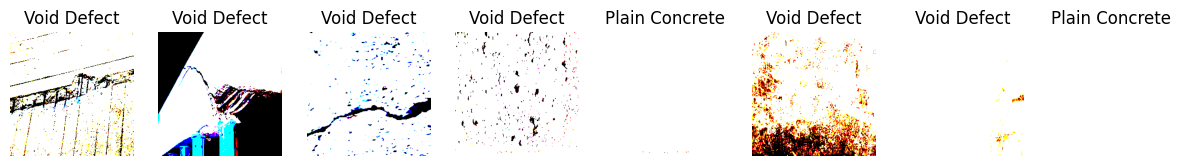

In [ ]:
import os
import numpy as np
import cv2
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define paths
test_folder = "/content/drive/MyDrive/voidModelAttempt1/newtest"
svm_model_path = "/content/drive/MyDrive/voidModelAttempt1/svm_model_tuned.pkl"
scaler_path = "/content/drive/MyDrive/voidModelAttempt1/scaler_tuned.pkl"

# Load trained SVM model and scaler
svm_model = joblib.load(svm_model_path)
scaler = joblib.load(scaler_path)

# Load ResNet50 model (feature extractor)
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Get test images
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

# Function to preprocess and extract features
def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = resnet_model.predict(img)
    return features.flatten(), img[0]  # Return both features and image for visualization

# Extract features and images
test_data = [extract_features(img) for img in test_images]
test_features = np.array([data[0] for data in test_data])
test_images_array = [data[1] for data in test_data]

# Scale features
test_features_scaled = scaler.transform(test_features)

# Predict using SVM model
predictions = svm_model.predict(test_features_scaled)

# Display results with images
fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))
for idx, (img_array, pred) in enumerate(zip(test_images_array, predictions)):
    label = "Void Defect" if pred == 1 else "Plain Concrete"
    axes[idx].imshow(img_array)
    axes[idx].axis("off")
    axes[idx].set_title(label)

plt.show()
